In [2]:
from Classification.src.Embedder import Embedder
from Classification.src.LLMClassifier import LLMClassifier
from Classification.src.Evaluator import Evaluator

import json
from flaml import AutoML
import pickle
import numpy as np
import matplotlib.pyplot as plt

from Classification.src.util import subsample
from Classification.src.util import num_tokens_from_string





/Users/pwag/repos/Classification-with-LLMs/venv/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [3]:
embedder_name = "distiluse-base-multilingual-cased-v2"

## Embedd the data

In [3]:
file_train = "./data/news/train.pkl"
file_test = "./data/news/test.pkl"

with open(file_train, "rb") as pickle_file:
    train = pickle.load(pickle_file)

with open(file_test, "rb") as pickle_file:
    test = pickle.load(pickle_file)


In [ ]:

embedder = Embedder(embedder_name)

train['embedding'] = embedder.embedd(train['data'])
#test['embedding'] = embedder.embedd(test['data'])

with open("./data/news/train_"+embedder_name+".pkl", "wb") as pickle_file:
    pickle.dump(dict(train), pickle_file)

with open("./data/news/test_"+embedder_name+".pkl", "wb") as pickle_file:
    pickle.dump(dict(test), pickle_file)


## Read the embedded data

In [3]:
file_train = "./data/news/train_"+embedder_name+".pkl"
file_test = "./data/news/test_"+embedder_name+".pkl"

with open(file_train, "rb") as pickle_file:
    train = pickle.load(pickle_file)

with open(file_test, "rb") as pickle_file:
    test = pickle.load(pickle_file)

## Analyse the dataset

In [4]:
for i,target in enumerate(train['target_names']):
    print(f"Topic: {target}")
    print([j for j,k in zip(train['data'], train['target']) if k == i][3])
    print("--------")

Topic: entertainment
Shah Rukh Khan-starrer Dunki is all set to release on December 21 and if all goes well for the star, this could be his third hit of the year. Dunki is the first film where director Rajkmar Hirani and SRK are collaborating together, and as per a recent report, the film was made on a reported cost of Rs 85 crore, which makes it one of the least expensive films of SRK in the recent years. However, this cost of Rs 85 crore does not include the cost of talent including SRK, Hirani, Taapsee Pannu, Vicky Kaushal and others.
As per a report in Pinkvilla, the film was made on a budget of Rs 85 crore and described Hirani as a “cautious spender.” The report said that Shah Rukh and Hirani are profit participants in the film and added that the cost of the film after adding the print and publicity cost was around Rs 120 crore. Dunki was reportedly shot in 75 days, out of which Shah Rukh shot for the film for 60 days.
This premium article is free for now..
Register to continue re

/var/folders/dg/8n0xxn4d09b0l8s58qy23x5snx2m3q/T/ipykernel_49402/4233822749.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[1].set_xticklabels(train['target_names'], rotation=45, ha='right', size=14);


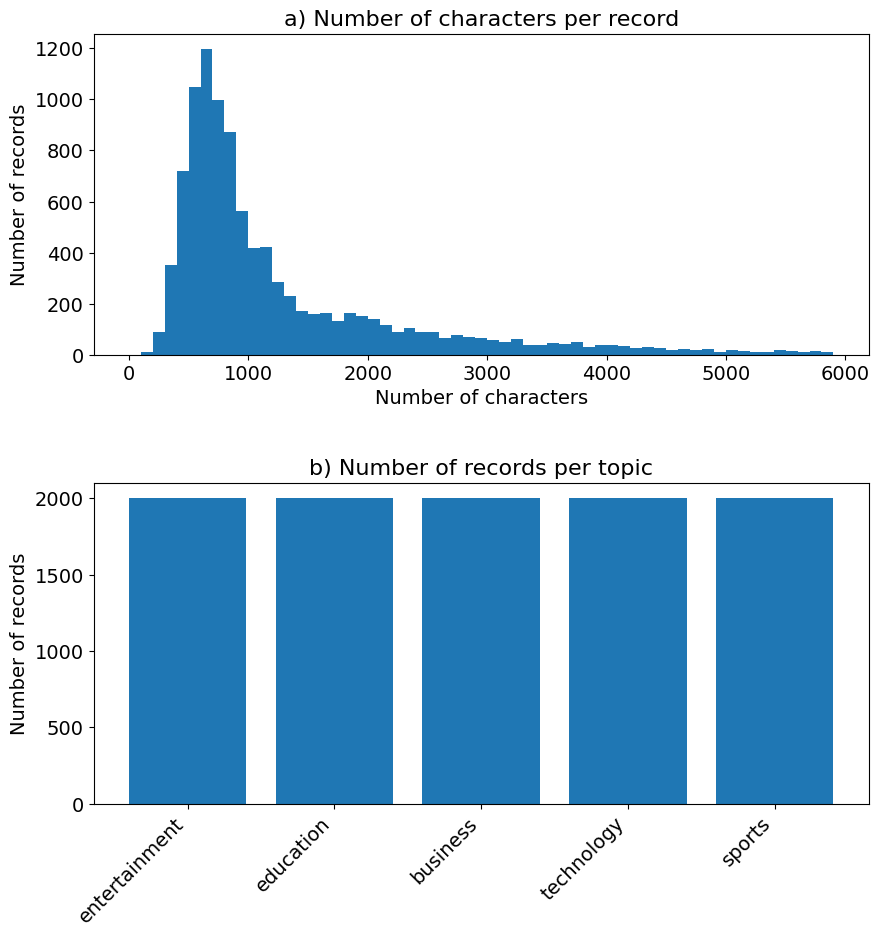

In [5]:
#fout="/Users/pwag/OneDrive - PPI AG/Dokumente/Artikel/Hyperparameter tuning with LLMs/Bilder/figure1.png"
n_classes = train['target'].value_counts() + test['target'].value_counts()
d = train['data'] + test['data']
t = np.concatenate((train['target'], test['target']))
#n_classes = []
# for i,target in enumerate(train['target_names']):
#     n_classes.append(len([j for j,k in zip(d, t) if k == i]))
n_character = [len(i) for i in train['data']] + [len(i) for i in test['data']]


fig, ax = plt.subplots(2,1, figsize=(10, 10))
ax[1].bar(train['target_names'], n_classes)
# historgram of n_character
ax[0].hist(n_character, bins=range(0,6000,100), color="C0")
# rotate x labels
ax[1].set_xticklabels(train['target_names'], rotation=45, ha='right', size=14);
ax[1].set_title("b) Number of records per topic", size=16)
ax[0].set_ylabel('Number of records', size=14)
ax[1].set_ylabel('Number of records', size=14)
ax[0].set_xlabel('Number of characters', size=14)
ax[0].set_title('a) Number of characters per record', size=16)
# set fontsize of xticklabel to 14
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[1].tick_params(axis='both', which='major', labelsize=14)
# increase space between subplots
fig.subplots_adjust(hspace=0.4)

#fig.savefig(fout)


In [6]:
print ("Number of characters")
print(f"Minimum: {min(n_character)}")
print(f"Maximum: {max(n_character)}")
print(f"Median: {np.median(n_character)}")

print("Train-Test split")
print(f"Train-Test ratio: {len(train['data']) / (len(train['data']) + len(test['data']))}")
print(f"Train: {len(train['data'])}")
print(f"Test: {len(test['data'])}")

Number of characters
Minimum: 101
Maximum: 15677
Median: 865.0
Train-Test split
Train-Test ratio: 0.8
Train: 8000
Test: 2000


### Estimate token usage

In [61]:
classifier_llm = LLMClassifier()
few_shot_prompt  = classifier_llm.create_few_shot_prompt(
    texts = train['data'],
    target = train['target'],
    topic_names = list(train['target_names'])
)

n_token_few_shot_prompts = 0
n_token_train = 0
n_token_test = 0

for prompt in few_shot_prompt:
    n_token_few_shot_prompts += num_tokens_from_string(prompt['content'], "cl100k_base")

for text in test['data']:
    n_token_test += n_token_few_shot_prompts
    n_token_test += num_tokens_from_string("Here is the text to classify:", "cl100k_base")
    n_token_test += num_tokens_from_string(text, "cl100k_base")

for text in train['data']:
    n_token_train += n_token_few_shot_prompts
    n_token_train += num_tokens_from_string("Here is the text to classify:", "cl100k_base")
    n_token_train += num_tokens_from_string(text, "cl100k_base")


In [64]:
cost_per_1m_token_gpt4o = 2.31514
cost_per_1m_token_gpt4omini = 0.13891

print(f"Input token in test data: {n_token_test}")
print(f"Input token in train data: {n_token_train}")
print(f"Estimated cost to evaluate test data with GPT4o: {round(n_token_test / 1e6 * cost_per_1m_token_gpt4o,2)} EUR")
print(f"Estimated cost to evaluate test data with GPT4omini: {round(n_token_test / 1e6 * cost_per_1m_token_gpt4omini,2)}")
print(f"Estimated cost to evaluate train data with GPT4o: {round(n_token_train / 1e6 * cost_per_1m_token_gpt4o,2)} EUR")
print(f"Estimated cost to evaluate train data GPT4omini: {round(n_token_train / 1e6 * cost_per_1m_token_gpt4omini,2)}")

Input token in test data: 4648530
Input token in train data: 18609662
Estimated cost to evaluate test data with GPT4o: 10.76 EUR
Estimated cost to evaluate test data with GPT4omini: 0.65
Estimated cost to evaluate train data with GPT4o: 43.08 EUR
Estimated cost to evaluate train data GPT4omini: 2.59


## Classify articles

### Use an LLM

In [4]:
# Classify the test data and add it to the dataset as target_predicted
classifier_llm = LLMClassifier()

classifier_llm.batch_classification(
    texts=test['data'][:10],
    topic_names=list(test['target_names']),
    train_text=train['data'],
    train_target=train['target']
)

# test['target_predicted_gpt4o'] = classifier_llm.y_pred
# with open(file_test, "wb") as pickle_file:
#    pickle.dump(dict(test), pickle_file)


9/9


In [4]:
# Classify the train data and add it to the dataset as target_predicted
classifier_llm_train = LLMClassifier()

classifier_llm_train.batch_classification(
    texts=train['data'],
    topic_names=list(train['target_names'])
)

train['target_predicted_gpt4omini'] = classifier_llm_train.y_pred
with open(file_train, "wb") as pickle_file:
    pickle.dump(dict(train), pickle_file)


1605/7999Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: https://go.microsoft.com/fwlink/?linkid=2198766", 'type': None, 'param': 'prompt', 'code': 'content_filter', 'status': 400, 'innererror': {'code': 'ResponsibleAIPolicyViolation', 'content_filter_result': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': True, 'severity': 'high'}, 'violence': {'filtered': False, 'severity': 'safe'}}}}}
2067/7999Error code: 400 - {'error': {'message': "The response was filtered due to the prompt triggering Azure OpenAI's content management policy. Please modify your prompt and retry. To learn more about our content filtering policies please read our documentation: h

### AutoML

In [4]:
classifiert_automl = AutoML()
automl_settings = {
    "time_budget": 60,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": f"./data/news/automl_s100_t900.log",
    "estimator_list": ['xgboost'],
}

classifiert_automl.fit(
    X_train=np.array(train['embedding']),
    y_train=np.array(train['target']),
    X_val=np.array(test['embedding']),
    y_val=np.array(test['target']),
    **automl_settings
)


# test['target_predicted_automl'] = list(classifiert_automl.predict(np.array(test['embedding'])))

# with open(file_test, "wb") as pickle_file:
#     pickle.dump(dict(test), pickle_file)

[flaml.automl.logger: 11-24 15:37:15] {1728} INFO - task = classification
[flaml.automl.logger: 11-24 15:37:15] {1736} INFO - Data split method: stratified
[flaml.automl.logger: 11-24 15:37:15] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-24 15:37:15] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 11-24 15:37:15] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 11-24 15:37:15] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 11-24 15:37:15] {2393} INFO - Estimated sufficient time budget=1876s. Estimated necessary time budget=2s.
[flaml.automl.logger: 11-24 15:37:15] {2442} INFO -  at 0.2s,	estimator xgboost's best error=0.0880,	best estimator xgboost's best error=0.0880
[flaml.automl.logger: 11-24 15:37:15] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-24 15:37:16] {2442} INFO -  at 0.4s,	estimator xgboost's best error=0.0880,	best estimator xgboost's be

In [31]:
# Train the model based on ChatGPTs label but validate it on the test data

classifiert_automl_gpt4ominilabel = AutoML()
automl_settings = {
    "time_budget": 900,  # in seconds
    "metric": 'accuracy',
    "task": 'classification',
    "log_file_name": f"./data/news/automl_gpt4ominilabel_s100_t900.log",
    "estimator_list": ['xgboost'],
}

X_train = [i for i,j in zip(train['embedding'], train['target_predicted_gpt4omini']) if j >= 0]
y_train = [i for i in train['target_predicted_gpt4omini'] if i >= 0]

classifiert_automl_gpt4ominilabel.fit(
    X_train=np.array(X_train),
    y_train=np.array(y_train),
    X_val=np.array(test['embedding']),
    y_val=np.array(test['target']),
    **automl_settings
)

test['target_predicted_automl_gpt4ominilabel'] = list(
    classifiert_automl_gpt4ominilabel.predict(np.array(test['embedding']))
)

with open(file_test, "wb") as pickle_file:
    pickle.dump(dict(test), pickle_file)

[flaml.automl.logger: 11-22 15:46:02] {1728} INFO - task = classification
[flaml.automl.logger: 11-22 15:46:02] {1736} INFO - Data split method: stratified
[flaml.automl.logger: 11-22 15:46:02] {1739} INFO - Evaluation method: holdout
[flaml.automl.logger: 11-22 15:46:02] {1838} INFO - Minimizing error metric: 1-accuracy
[flaml.automl.logger: 11-22 15:46:02] {1955} INFO - List of ML learners in AutoML Run: ['xgboost']
[flaml.automl.logger: 11-22 15:46:02] {2258} INFO - iteration 0, current learner xgboost
[flaml.automl.logger: 11-22 15:46:02] {2393} INFO - Estimated sufficient time budget=2214s. Estimated necessary time budget=2s.
[flaml.automl.logger: 11-22 15:46:02] {2442} INFO -  at 0.3s,	estimator xgboost's best error=0.1110,	best estimator xgboost's best error=0.1110
[flaml.automl.logger: 11-22 15:46:02] {2258} INFO - iteration 1, current learner xgboost
[flaml.automl.logger: 11-22 15:46:03] {2442} INFO -  at 0.5s,	estimator xgboost's best error=0.1015,	best estimator xgboost's be

## Evaluate the results

In [4]:
file_test = "./data/news/test_"+embedder_name+".pkl"

with open(file_test, "rb") as pickle_file:
    test = pickle.load(pickle_file)

In [5]:
GPT4omini_Evaluator = Evaluator()
GPT4omini_Evaluator.evaluate(test, 'target_predicted_gpt4omini')

Number of records: 2000
Number of records filtered by Azures content filter: 4
               precision    recall  f1-score   support

entertainment       1.00      0.84      0.91       400
    education       0.93      0.98      0.95       399
     business       0.82      0.95      0.88       400
   technology       0.95      0.89      0.92       399
       sports       0.97      0.98      0.98       398

     accuracy                           0.93      1996
    macro avg       0.93      0.93      0.93      1996
 weighted avg       0.93      0.93      0.93      1996



In [6]:
GPT4o_Evaluator = Evaluator()
GPT4o_Evaluator.evaluate(test, 'target_predicted_gpt4o')

Number of records: 2000
Number of records filtered by Azures content filter: 4
               precision    recall  f1-score   support

entertainment       1.00      0.96      0.98       400
    education       0.96      0.99      0.98       399
     business       0.95      0.91      0.93       400
   technology       0.91      0.93      0.92       399
       sports       0.97      1.00      0.98       398

     accuracy                           0.96      1996
    macro avg       0.96      0.96      0.96      1996
 weighted avg       0.96      0.96      0.96      1996



In [7]:
#test['target_predicted_automl'] = list(test['target_predicted_automl'])

AutoML_Evaluator = Evaluator()
AutoML_Evaluator.evaluate(test, 'target_predicted_automl')

Number of records: 2000
               precision    recall  f1-score   support

entertainment       0.99      0.99      0.99       400
    education       0.99      0.98      0.99       400
     business       0.97      0.98      0.97       400
   technology       0.98      0.97      0.97       400
       sports       0.99      0.99      0.99       400

     accuracy                           0.98      2000
    macro avg       0.98      0.98      0.98      2000
 weighted avg       0.98      0.98      0.98      2000



In [8]:
AutoML_gpt4ominilabel_Evaluator = Evaluator()
AutoML_gpt4ominilabel_Evaluator.evaluate(test, 'target_predicted_automl_gpt4ominilabel')

Number of records: 2000
               precision    recall  f1-score   support

entertainment       0.94      0.98      0.96       400
    education       0.95      0.98      0.96       400
     business       0.84      0.97      0.90       400
   technology       0.98      0.75      0.85       400
       sports       0.98      0.98      0.98       400

     accuracy                           0.93      2000
    macro avg       0.94      0.93      0.93      2000
 weighted avg       0.94      0.93      0.93      2000



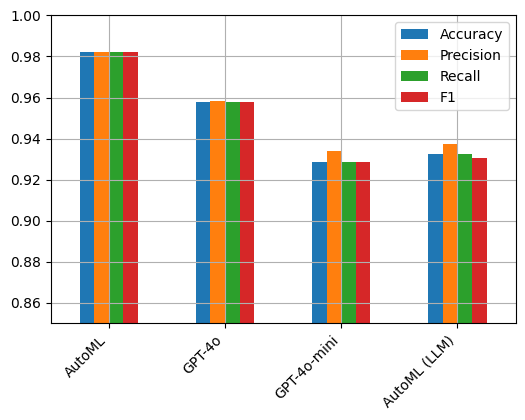

In [9]:
# barplot of accuracy, precision, recall, f1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.DataFrame({
    'Accuracy': [AutoML_Evaluator.accuracy, GPT4o_Evaluator.accuracy, GPT4omini_Evaluator.accuracy,  AutoML_gpt4ominilabel_Evaluator.accuracy],
    'Precision': [AutoML_Evaluator.precision, GPT4o_Evaluator.precision, GPT4omini_Evaluator.precision,  AutoML_gpt4ominilabel_Evaluator.precision],
    'Recall': [ AutoML_Evaluator.recall, GPT4o_Evaluator.recall, GPT4omini_Evaluator.recall, AutoML_gpt4ominilabel_Evaluator.recall],
    'F1': [AutoML_Evaluator.f1, GPT4o_Evaluator.f1, GPT4omini_Evaluator.f1,  AutoML_gpt4ominilabel_Evaluator.f1],
    'Model': ['AutoML', 'GPT-4o', 'GPT-4o-mini', 'AutoML (LLM)']
})

y = ['Accuracy', 'Precision', 'Recall', 'F1']
ax = df.plot.bar(x='Model', y=y, rot=0, figsize=(6, 4))
ax.set_ylim(0.85, 1)
ax.grid(True)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

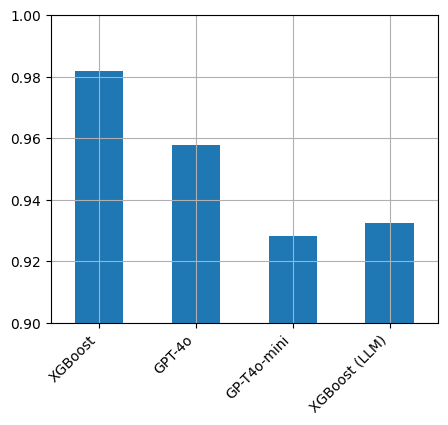

Accuracy:  0.982 0.9579158316633266 0.9283567134268537 0.9325


In [10]:
# barplot of accuracy, precision, recall, f1

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

df = pd.DataFrame({
    'Accuracy': [AutoML_Evaluator.accuracy, GPT4o_Evaluator.accuracy, GPT4omini_Evaluator.accuracy,  AutoML_gpt4ominilabel_Evaluator.accuracy],
    #'Precision': [AutoML_Evaluator.precision, GPT4o_Evaluator.precision, GPT4omini_Evaluator.precision,  AutoML_gpt4ominilabel_Evaluator.precision],
    #'Recall': [ AutoML_Evaluator.recall, GPT4o_Evaluator.recall, GPT4omini_Evaluator.recall, AutoML_gpt4ominilabel_Evaluator.recall],
    #'F1': [AutoML_Evaluator.f1, GPT4o_Evaluator.f1, GPT4omini_Evaluator.f1,  AutoML_gpt4ominilabel_Evaluator.f1],
    'Model': ['XGBoost', 'GPT-4o', 'GP-T4o-mini', 'XGBoost (LLM)']
})

y = ['Accuracy']
ax = df.plot.bar(x='Model', y=y, rot=0, figsize=(5, 4), legend=False)
ax.set_ylim(0.9, 1)
ax.grid(True)
ax.set_xlabel('')
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
plt.show()

print("Accuracy: ", AutoML_Evaluator.accuracy, GPT4o_Evaluator.accuracy, GPT4omini_Evaluator.accuracy,  AutoML_gpt4ominilabel_Evaluator.accuracy)

In [ ]:
# Print the articles that triggered Azure's content filter
#get index where test['target_predicted_gpt4omini'] == -2

[i for i,j in zip(test['data'], test['target_predicted_gpt4o']) if j == -2]


['Written by Brian X. Chen\nFor the past two weeks, I’ve been using a new camera to secretly snap photos and record videos of strangers in parks, on trains, inside stores and at restaurants. (I promise it was all in the name of journalism.) I wasn’t hiding the camera, but I was wearing it, and no one noticed.\nThis premium article is free for now..\nRegister to continue reading.\nRegister\nAlready have an account? Sign in',
 'NEET UG 2024: Sumegha Sinha bagged 39th all-India rank in the National Eligibility-cum-Entrance Test Undergraduate (NEET UG) 2023 by scoring 710 marks out of 720. Sinha is now pursuing her MBBS from ABVIMS and Dr. RML Hospital, New Delhi.\nThe 18-year-old from Jamshedpur, Jharkhand, scored 93 per cent in Class 10 and 94.6 per cent marks in Class 12.\nYou have exhausted your monthly limit of free stories.\nRegister to read more stories\nContinue With:-\nGoogle\nFacebook\nEmail\nAlready have an account? Sign in',
 'Vitoria, a Brazilian football club, announced a new